In [1]:
import time 
import numpy as np

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
mnist_data = input_data.read_data_sets('mnist_data')

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


In [7]:
def plot_images(imgs):
    r, c = 5, 5
    # Rescale images 0 - 1
    gen_imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            
            axs[i,j].imshow(gen_imgs[cnt, :,:], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1

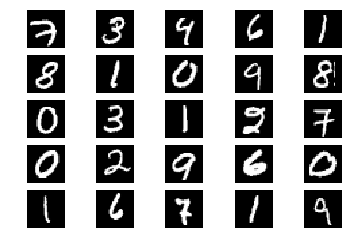

In [14]:
plot_images(mnist_data.train.images.reshape((-1, 28, 28)))

In [15]:
imgs = mnist_data.train.images
mnist_imgs = imgs.reshape(imgs.shape[0], 28, 28)

In [16]:
def normalize_imgs(imgs):
    assert imgs.shape[1] == 28 * 28
    return (mnist_imgs - 127.5) / 127.5

In [38]:
def D(x, dropout_rate, is_training, reuse = True, print_summary = True):
    num_classes = 10
    with tf.variable_scope('Discriminator', reuse = reuse) as scope:
        #layer 1
        conv1 = tf.layers.conv2d(x, 32, [5,5], strides=[2,2], padding='same')
        lrelu1 = tf.nn.leaky_relu(conv1, alpha=0.2)
        dropout1 = tf.layers.dropout(lrelu1, dropout_rate)
        
        #layer 2
        conv2 = tf.layers.conv2d(dropout1, 64, [3,3], strides=[2,2], padding='same')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=is_training)
        lrelu2 = tf.nn.leaky_relu(conv1, alpha=0.2)
        
        #layer 3
        conv3 = tf.layers.conv2d(lrelu2, 128, [2, 2],
                         strides = [2, 2],
                         padding = 'same')
        batch_norm3 = tf.layers.batch_normalization(conv3, training = is_training)
        lrelu3 = tf.maximum(0.2 * batch_norm3, batch_norm3)
        dropout3 = tf.layers.dropout(lrelu3, dropout_rate)
        #layer 4
        conv4 = tf.layers.conv2d(dropout3, 128, [2, 2],
                                 strides = [2, 2],
                                 padding = 'same')
        # do not use batch_normalization on this layer - next layer, "flatten5",
        # will be used for "Feature Matching"
        lrelu4 = tf.maximum(0.2 * conv4, conv4)
        
        flatten_length = lrelu4.get_shape().as_list()[1] * \
                         lrelu4.get_shape().as_list()[2] * lrelu4.get_shape().as_list()[3]
        flatten5 = tf.reshape(lrelu4, (-1, flatten_length)) # used for "Feature Matching" 
        fc5 = tf.layers.dense(flatten5, (num_classes + 1))
        output = tf.nn.softmax(fc5)

        assert output.get_shape()[1:] == [num_classes + 1]
        if print_summary:
            print('Discriminator summary:\n x: %s\n' \
                  ' D1: %s\n D2: %s\n D3: %s\n D4: %s\n' %(x.get_shape(), 
                                                           dropout1.get_shape(),
                                                           lrelu2.get_shape(), 
                                                           dropout3.get_shape(),
                                                           lrelu4.get_shape()))
            
        return flatten5, fc5, output

In [63]:
def G(z, is_training, reuse = False, print_summary = False):
    # generator (z -> x)

    with tf.variable_scope('Generator', reuse = reuse) as scope:
        # layer 0
        z_reshaped = tf.reshape(z, [-1, 1, 1, latent_size])

        # layer 1
        deconv1 = tf.layers.conv2d_transpose(z_reshaped,
                                             filters = latent_size,
                                             kernel_size = [2, 2],
                                             strides = [1, 1],
                                             padding = 'valid')
        batch_norm1 = tf.layers.batch_normalization(deconv1, training = is_training)
        relu1 = tf.nn.relu(batch_norm1)

        # layer 2
        deconv2 = tf.layers.conv2d_transpose(relu1,
                                             filters = 64,
                                             kernel_size = [3, 3],
                                             strides = [2, 2],
                                             padding = 'valid')
        batch_norm2 = tf.layers.batch_normalization(deconv2, training = is_training)
        relu2 = tf.nn.relu(batch_norm2)

        # layer 3
        deconv3 = tf.layers.conv2d_transpose(relu2,
                                             filters = 32,
                                             kernel_size = [4, 4],
                                             strides = [2, 2],
                                             padding = 'valid')
        batch_norm3 = tf.layers.batch_normalization(deconv3, training = is_training)
        relu3 = tf.nn.relu(batch_norm3)

        # layer 4 - do not use Batch Normalization on the last layer of Generator
        deconv4 = tf.layers.conv2d_transpose(relu3,
                                             filters = num_channels,
                                             kernel_size = [6, 6],
                                             strides = [2, 2],
                                             padding = 'valid')
        tanh4 = tf.tanh(deconv4)

        assert tanh4.get_shape()[1:] == [x_height, x_width, num_channels]
        if print_summary:
            print('Generator summary:\n z: %s\n' \
                  ' G0: %s\n G1: %s\n G2: %s\n G3: %s\n G4: %s\n' %(z.get_shape(),
                                                                    z_reshaped.get_shape(),
                                                                    relu1.get_shape(),
                                                                    relu2.get_shape(),
                                                                    relu3.get_shape(),
                                                                    tanh4.get_shape()))
        return tanh4

In [94]:
def build_model(x_real, z, label, dropout_rate, is_training, print_summary=True):
    D_real_features, D_real_prob, D_real_logit = D(x_real, dropout_rate, is_training, print_summary=True, reuse=False)
    fakes = G(z, is_training=is_training, print_summary=print_summary, reuse=False)
    D_real_features, D_real_prob, D_real_logit = D(fakes, dropout_rate, is_training, print_summary=print_summary, reuse=True)
    
    return D_real_features, D_real_prob, D_real_logit, D_real_features, D_real_prob, D_real_logit

tf.reset_default_graph()
num_classes = 10
latent_size = 100
num_channels = 1
x_height = 28
x_width = 28

x_real = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32)
z = tf.placeholder(shape=[None, latent_size], dtype=tf.float32)



label = tf.placeholder(shape=[None, num_classes + 1], dtype=tf.float32)
dropout_rate = tf.constant(value=0.2, dtype=tf.float32)
is_training = tf.constant(True, dtype=tf.bool)

D_real_features, D_real_prob, D_real_logit, D_real_features, D_real_prob, D_real_logit = build_model(x_real, z, label, dropout_rate, is_training, print_summary=True)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess

Discriminator summary:
 x: (?, 28, 28, 1)
 D1: (?, 14, 14, 32)
 D2: (?, 14, 14, 32)
 D3: (?, 7, 7, 128)
 D4: (?, 4, 4, 128)

Generator summary:
 z: (?, 100)
 G0: (?, 1, 1, 100)
 G1: (?, 2, 2, 100)
 G2: (?, 5, 5, 64)
 G3: (?, 12, 12, 32)
 G4: (?, 28, 28, 1)

Discriminator summary:
 x: (?, 28, 28, 1)
 D1: (?, 14, 14, 32)
 D2: (?, 14, 14, 32)
 D3: (?, 7, 7, 128)
 D4: (?, 4, 4, 128)



In [96]:
def prepare_labels(label):
    return tf.concat([label, tf.zeros([tf.shape(label)[0], 1])], 1)

def get_labled_mask(labeled_rate, batch_size):
    # get labeled mask to mask some data unlabeled
    labeled_mask = np.zeros([batch_size], dtype = np.float32)
    labeled_count = np.int(batch_size * labeled_rate)
    labeled_mask[range(labeled_count)] = 1.0
    #np.random.shuffle(labeled_mask)

    return labeled_mask

const = tf.constant([[1, 0], [0,1], [1, 1]], dtype=tf.float32)
a = prepare_labels(const)
with tf.Session() as sess:
    assert(a.get_shape()[0] == const.get_shape()[0])
    assert(a.get_shape()[1] == const.get_shape()[1] + 1)
    print(a.eval())

[[1. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]]


In [66]:
def loss_function(D_real_features, D_real_logit, D_real_prob, D_fake_features, D_fake_logit, D_fake_prob, extended_label, labeled_mask):
    epsilon = 1e-8
    
    # Discrimator loss
    L_supervised_tmp = tf.nn.softmax_cross_entropy_with_logits(D_real_logit, extended_label)
    L_supervised = tf.reduce_sum(labeled_mask * L_supervised_tmp) / tf.reduce_sum(labeled_mask)
    
    # data is real
    prob_real_to_real = 1.0 - D_real_prob[ : , -1] + epsilon
    tmp_log_real = - tf.reduce_sum(tf.log(prob_real_to_real))
    
    prob_fake_to_fake = D_fake_prob[ : , -1] + epsilon
    tmp_log_fake = - tf.reduce_sum(tf.log(prob_fake_to_fake))
    
    L_unsupervised = tmp_log_real + tmp_log_fake
    
    L_D = L_supervised + L_unsupervised
    
    # Generator loss
    
    prob_fake_to_real = 1 - D_fake_prob[:,-1] + epsilon
    L_G_ =  - tf.reduce_sum(tf.log(prob_fake_real))
    
    tmp1 = tf.reduce_mean(D_real_features, axis=0)
    tmp2 = tf.reduce_mena(D_fake_features, axis=1)
    
    L_G_feat = tf.reduce_mean(tf.square(tmp1 - tmp2))
    
    L_G = L_G_ + L_G_feat
    
    # accuracy
    correct_prediction = tf.equal(tf.argmax(D_real_prob[:, -1]), tf.arg_max(extended_label))
    accuracy = tf.reduce_mean(tf.case(correct_prediction, tf.float32))
    
    return L_supervised, L_unsupervised, L_D, L_G,  accuracy

In [95]:
def optimizer(L_D, L_G, D_lr, G_lr):
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        all_vars = tf.trainable_variables()
        
        D_vars = [var for var in all_vars if var.name.startswith("Discimanator")]
        G_vars = [var for var in all_vars if var.name.startswith("Generator")]
        
        D_optimizer = tf.train.AdamOptimizer(D_lr).minimize(L_D, var_list = D_vars)
        G_optimizer = tf.train.AdamOptimizer(G_lr).minimize(L_G, var_list = G_vars)
        
        return D_optimizer, G_optimizer

In [40]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, name='x', shape=[None, 28, 28, 1])
_, _, output = D(x, dropout_rate=0.5, is_training=True, reuse=False)

data = mnist_data.train.images.reshape((-1, 28, 28, 1))[:5]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(output, feed_dict={x : data}))

Discriminator summary:
 x: (?, 28, 28, 1)
 D1: (?, 14, 14, 32)
 D2: (?, 14, 14, 32)
 D3: (?, 7, 7, 128)
 D4: (?, 4, 4, 128)

[[0.09795775 0.06131464 0.12118444 0.08770289 0.03940316 0.04761093
  0.11806776 0.143454   0.06382775 0.08196361 0.13751309]
 [0.07047343 0.19905777 0.07020228 0.02854647 0.14493899 0.08255848
  0.05120336 0.12316027 0.06651125 0.07817858 0.08516911]
 [0.11947495 0.12559225 0.070233   0.03976812 0.10073313 0.07451557
  0.06713982 0.10653196 0.12310825 0.07246795 0.100435  ]
 [0.0758586  0.10891456 0.09249167 0.0323479  0.06780415 0.12071832
  0.07105544 0.09879178 0.06465167 0.11665436 0.15071149]
 [0.0775812  0.08719668 0.06913411 0.03712842 0.08646975 0.07051375
  0.09233648 0.1481484  0.08790158 0.10120428 0.14238536]]


In [62]:
def train():
    tf.reset_default_graph()
    
    epochs = 2
    labeled_rate = 0.1
    
    x = tf.placeholder(tf.float32, name="x", shape=[None, 28, 28, 1])
    label = tf.placeholder(tf.float32, name="label", shape=[None, num_classes])
    extended_label = tf.placeholder(tf.float32, name="ext_label", shape=[None, num_classes + 1])
    
    mask = tf.placeholder(tf.float32, name="mask", shape=[None, num_classes + 1])
    
    noise = tf.placeholder(tf.float32, name="noise", shape=[None, latent_size])
    dropout_rate = tf.constant(tf.float32, name="dropout_rate")
    is_training = tf.constant(tf.bool, name="is_training")
    
    D_real_features, D_real_prob, D_real_logit, D_real_features, D_real_prob, D_real_logit = build_model(x_real, z, label, dropout_rate, is_training, print_summary=True)
    
    L_supervised, L_unsupervised, L_D, L_G,  accuracy = loss_function(D_real_features, D_real_prob, D_real_logit, D_real_features, D_real_prob, D_real_logit, extended_label, mask)
    G_lr = tf.placeholder(tf.float32, name = 'G_learning_rate')
    D_lr = tf.placeholder(tf.float32, name = 'D_learning_rate')
    D_opt, G_opt = optimizer(L_D, L_G, G_learning_rate, D_learning_rate)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        mnist_dataset = get_data()
        
        for epoch in range(epochs):
            
            batch = mnist_dataset.train.next_batch(batch_size, shuffle = False) ## No shuffle here
            batch_z = np.random.uniform(-1, 1, size=(batch_size, latent_size))
            
            mask = get_labled_mask(labeled_rate, batch_size)
            
            train_feed_dict = {
                x : normalize_imgs(batch[1]),
                label : batch[1],
                noise : batch_z,
                
                dropout_rate : 0.5,
                G_lr : 1e-5,
                D_lr : 1e-5,
                is_training : True
            }
            
            
        
        

/Users/admin/Keras-GAN/venv/bin/python
